In [1]:
#!pip install sklearn
#!pip install bcml4pheno
#!pip install tensorflow 

In [2]:
import os
import csv
import math 
import numpy as np
import pandas as pd
import ROOT
from bcml4pheno import bcml_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.22/06


2022-09-16 17:06:59.506198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Collider/ROOT/installROOT/lib::/Collider/ROOT/installROOT/lib/:/Collider/fastjet/lib:/Collider/fastjet/lib64:/Collider/LHAPDF/lib
2022-09-16 17:06:59.506235: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print(os.getcwd())

/disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis


In [4]:
def read_csv(folder, name):
    dict_={}
    ax=next(os.walk(folder))[2]
    ax.sort(reverse = True )
    for file in ax:
        if "Cutflow" in file: continue
        elif name in file:
            try:
                df=pd.read_csv(
                    os.path.join(folder,file)
                )
                dict_.update(
                    {file.removesuffix(f"_{name}") : df}
                )
            except:
                pass
    return dict_

def load_all_csv(folder):
    data_dict={}
    results_names=[
        #hadronic selection
        "b_tau_tau_hadronic_zero_jets",
        "b_tau_tau_hadronic_(al)one_jet",
        "b_b_tau_tau_hadronic",
        #semileptonic selection
        "b_tau_tau_semileptonic_zero_jets",
        "b_tau_tau_semileptonic_(al)one_jet",
        "b_b_tau_tau_semileptonic",
        #leptonic selection
        "b_tau_tau_leptonic_zero_jets",
        "b_tau_tau_leptonic_(al)one_jet",
        "b_b_tau_tau_leptonic"
    ]
    for name in results_names:
        data_dict.update({name: read_csv(folder,f"{name}.csv")})
    return data_dict


In [5]:
def prepare_features(data_dict,name='',channel="",features=[]):
    signal_feature=[]
    for i in range(data_dict[channel][name].shape[0]):
        row=[]
        for feature in features:
            row+=[data_dict[channel][name][feature][i]]        
        signal_feature.append(row)
    return np.array(signal_feature)

def concat_signals(data_dict,signal_list,channel,features):
    names=signal_list.copy()
    name_0=names.pop(0)
    arr=prepare_features(data_dict,name_0,channel,features)[:,:]
    for name in names:
        arr=np.concatenate((arr,prepare_features(data_dict,name,channel,features)[:,:]))
    np.random.shuffle(arr)
    return arr

def concat_channels(data_dict,signal_list,channels,features):
    chs=channels.copy()
    ch_0=chs.pop(0)
    arr=concat_signals(data_dict,signal_list,ch_0,features)
    for channel in chs:
        arr=np.concatenate((arr,concat_signals(data_dict,signal_list,channel,features)[:,:]))
    np.random.shuffle(arr)
    return arr

In [6]:
def prepare_to_train (signal,bkg):
    bkg_vsize=min([len(signal),len(bkg)])
    signal_vsize=bkg_vsize

    pred=signal[:signal_vsize, :]
    pred=np.concatenate((pred,bkg[:bkg_vsize, :]))
    
    labels=np.zeros(np.shape(pred)[0])
    labels[:signal_vsize] = 1
    
    return pred , labels
def get_yield(csv_files_path,signal_list,channel):
    df=pd.read_csv(
            os.path.join(
                csv_files_path,
                f"Cutflow_{channel}.csv"
            )
        )
    yields=0
    for name in signal_list:
        yields+=df[name][(df.shape[0]-1)]
    return yields
def get_yields(csv_files_path,names,channels):
    dict_={}
    for channel in channels:
        dict_[channel]={}
        for name in names: 
            dict_[channel][name]=get_yield(csv_files_path,[name],channel)
    return dict_

In [7]:
from ROOT import *

def Draw_Discrtiminator(data_dict,name,channels,csv_files_path,images_folder,model,features):
    c1 = TCanvas( f'c-{name}', '', 0, 0, 1280, 720)
    c1.SetGrid()
    c1.SetLogy()
    hs = THStack(name,name)
    colors = [kBlue,kRed,3, 7, 6, kBlack, 2,  9, 1, 43, 97, 38, 3, 7, 6, kBlack, 2, 4, 8]
    hist_dict={}
    for i, channel in enumerate(channels):
        h = TH1F(f"{name}_{channel}",f"{name}_{channel};score;nevents(137/fb)", 100, 0.0,1.0)
        h.SetLineWidth(1)
        h.SetLineColor(kBlack)
        h.SetFillColor(colors[i])
        for score in model.predict_proba(concat_signals(data_dict,[name],channel,features)):
            h.Fill(score)
        h.Scale(get_yield(csv_files_path,[name],channel)/h.Integral())
        hist_dict[channel]=h
        hs.Add(h)
    hs.Draw("HIST")
    c1.SaveAs(os.path.join(os.getcwd(),images_folder,f"{name}.png"))
    return (name,hist_dict)

In [8]:
folder_out=os.path.join(
    os.path.dirname(os.getcwd()),
    "03_delphes_analysis"
)
csv_files_path=os.path.join(folder_out,"csv_files")
print(csv_files_path)

data=load_all_csv(csv_files_path)

print(list(data.keys()))

/disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/csv_files
['b_tau_tau_hadronic_zero_jets', 'b_tau_tau_hadronic_(al)one_jet', 'b_b_tau_tau_hadronic', 'b_tau_tau_semileptonic_zero_jets', 'b_tau_tau_semileptonic_(al)one_jet', 'b_b_tau_tau_semileptonic', 'b_tau_tau_leptonic_zero_jets', 'b_tau_tau_leptonic_(al)one_jet', 'b_b_tau_tau_leptonic']


In [9]:
channel="b_b_tau_tau_hadronic"
#channels=[
    #"b_tau_tau_hadronic_(al)one_jet",
    #"b_tau_tau_hadronic_zero_jets",
    #"b_b_tau_tau_hadronic"
#]
channels=[channel]

In [10]:
a=list(data[channel]["ww"])
a.sort(reverse = True)
a

['pT_{b_{2}}(GeV)',
 'pT_{b_{1}}(GeV)',
 'pT_{#tau_{2}}(GeV)',
 'pT_{#tau_{1}}(GeV)',
 'light_jets_multiplicity',
 'Q_#tau_{1}Q_#tau_{2}',
 'Mass_{b_{2}}(GeV)',
 'Mass_{b_{1}}(GeV)',
 'Mass_{#tau_{2}}(GeV)',
 'Mass_{#tau_{1}}(GeV)',
 'MET(GeV)',
 'Energy_{b_{2}}(GeV)',
 'Energy_{b_{1}}(GeV)',
 'Energy_{#tau_{2}}(GeV)',
 'Energy_{#tau_{1}}(GeV)',
 '#phi_{b_{2}}',
 '#phi_{b_{1}}',
 '#phi_{MET}',
 '#phi_{#tau_{2}}',
 '#phi_{#tau_{1}}',
 '#eta_{b_{2}}',
 '#eta_{b_{1}}',
 '#eta_{#tau_{2}}',
 '#eta_{#tau_{1}}',
 '#Delta{pT}_{b_{2}#tau_{2}}(GeV)',
 '#Delta{pT}_{b_{2}#tau_{1}}(GeV)',
 '#Delta{pT}_{b_{1}b_{2}}(GeV)',
 '#Delta{pT}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{pT}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{pT}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{R}_{b_{2}#tau_{2}}',
 '#Delta{R}_{b_{2}#tau_{1}}',
 '#Delta{R}_{b_{1}b_{2}}',
 '#Delta{R}_{b_{1}#tau_{2}}',
 '#Delta{R}_{b_{1}#tau_{1}}',
 '#Delta{R}_{#tau_{1}#tau_{2}}',
 '#Delta{#vec{p}}_{b_{2}#tau_{2}}(GeV)',
 '#Delta{#vec{p}}_{b_{2}#tau_{1}}(GeV)',
 '#Delta{#v

In [11]:
features=[
    'light_jets_multiplicity',
    'MET(GeV)',
    '#phi_{MET}',
    
    'Mass_{b_{1}}(GeV)',
    'pT_{b_{1}}(GeV)',
    '#phi_{b_{1}}',
    '#eta_{b_{1}}',
    
    'Mass_{b_{2}}(GeV)',
    'pT_{b_{2}}(GeV)',
    '#phi_{b_{2}}',
    '#eta_{b_{2}}',
    
    'Mass_{#tau_{1}}(GeV)',
    'pT_{#tau_{1}}(GeV)',
    '#phi_{#tau_{1}}',
    '#eta_{#tau_{1}}',
    
    'Mass_{#tau_{2}}(GeV)',
    'pT_{#tau_{2}}(GeV)',
    '#phi_{#tau_{2}}',
    '#eta_{#tau_{2}}'
]

In [12]:
mass=1000
if mass < 1000:
    name=f"LQ_LQ_0{mass}"
    name2=f"Tau_LQ_0{mass}"
else :
    name=f"LQ_LQ_{mass}"
    name2=f"Tau_LQ_{mass}"
signal_names=[
    name
]
bkg_names=[
    "ttbar",
    "stop",
    "z_jets",
    "w_jets",
    "ww",
    "wz",
    "zz"
]

signal= concat_channels(data,signal_names,channels,features)
bkg= concat_channels(data,bkg_names,channels,features)

In [13]:
sig_yield=get_yields(csv_files_path,signal_names,channels)
bkg_yield=get_yields(csv_files_path,bkg_names,channels)
print(sig_yield)
print(bkg_yield)

{'b_b_tau_tau_hadronic': {'LQ_LQ_1000': 1000.8889477714288}}
{'b_b_tau_tau_hadronic': {'ttbar': 44833.05889691348, 'stop': 3668.223105681818, 'z_jets': 4459.745413975855, 'w_jets': 7669.306893344798, 'ww': 16.5130953088, 'wz': 34.6863949319797, 'zz': 103.88704366560002}}


In [14]:
pred1 , labels1= prepare_to_train(signal,bkg)
trainPred, testPred, trainLab, testLab = train_test_split(pred1, labels1, test_size=0.25)

logreg_model = bcml_model(
    make_pipeline(
        StandardScaler(), 
        LogisticRegression()
    )
)

logreg_model.fit(trainPred, trainLab)

In [15]:
logreg_model.tpr(testLab, preds=testPred)

0.9841124350748549

In [16]:
logreg_model.fpr(testLab, preds=testPred)

0.011959521619135235

In [17]:
signal_names=[name,name2]
images_folder=os.path.join(f"MLQ_{mass}",f"{channels[0]}")
os.system(f"rm -rf '{images_folder}'")
os.system(f"mkdir -p '{images_folder}'")
def mapping(name):
    return Draw_Discrtiminator(data,name,channels,csv_files_path,images_folder,logreg_model,features)
histograms=dict(map(mapping,signal_names+bkg_names))

Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/MLQ_1000/b_b_tau_tau_hadronic/LQ_LQ_1000.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/MLQ_1000/b_b_tau_tau_hadronic/Tau_LQ_1000.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/MLQ_1000/b_b_tau_tau_hadronic/ttbar.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/MLQ_1000/b_b_tau_tau_hadronic/stop.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/MLQ_1000/b_b_tau_tau_hadronic/z_jets.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/MLQ_1000/b_b_tau_tau_hadronic/w_jets.p

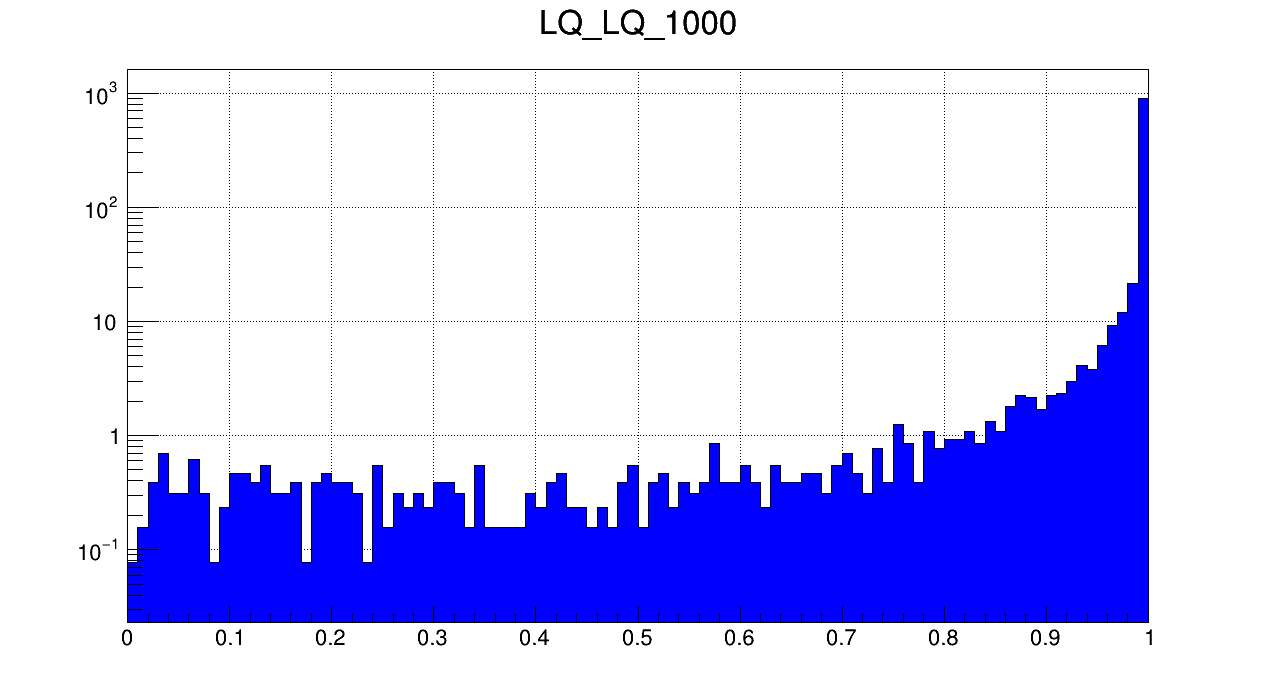

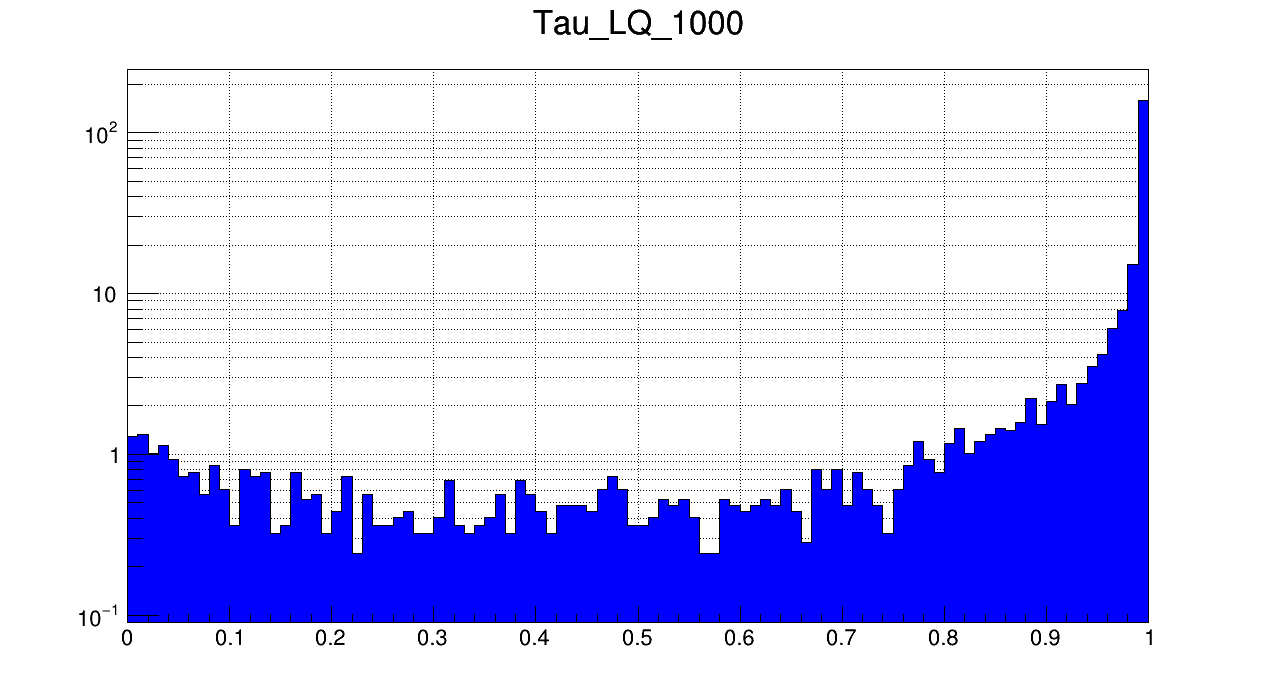

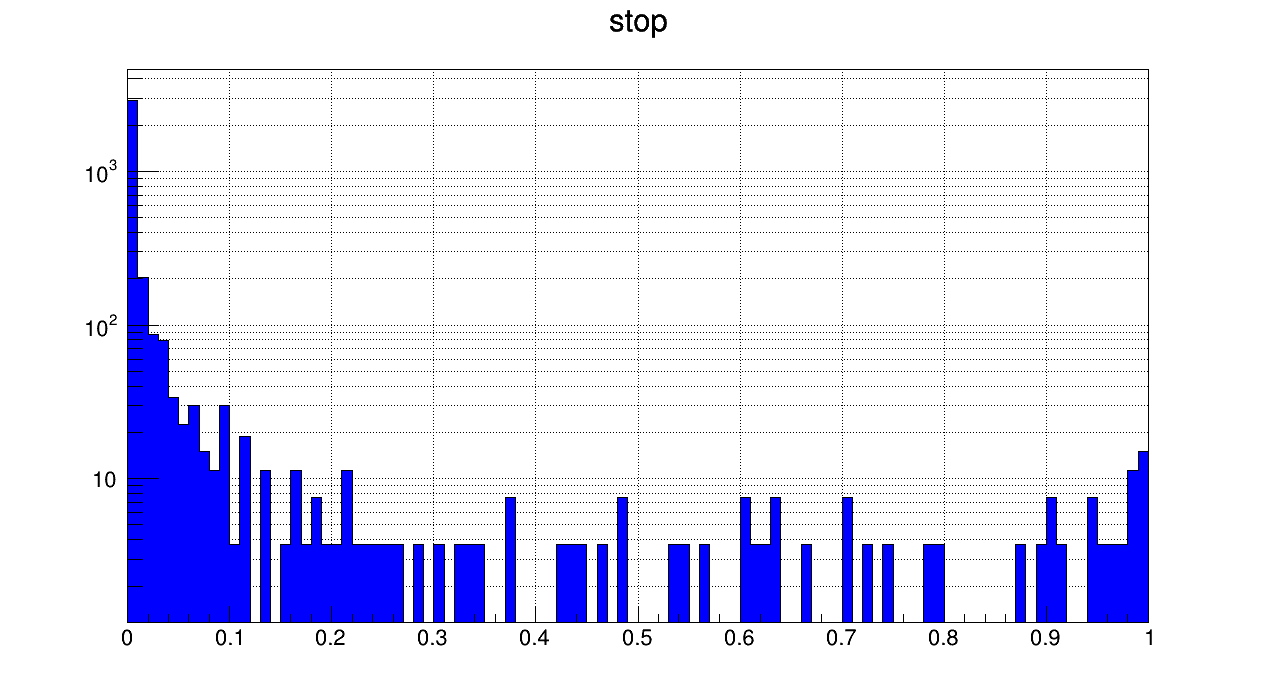

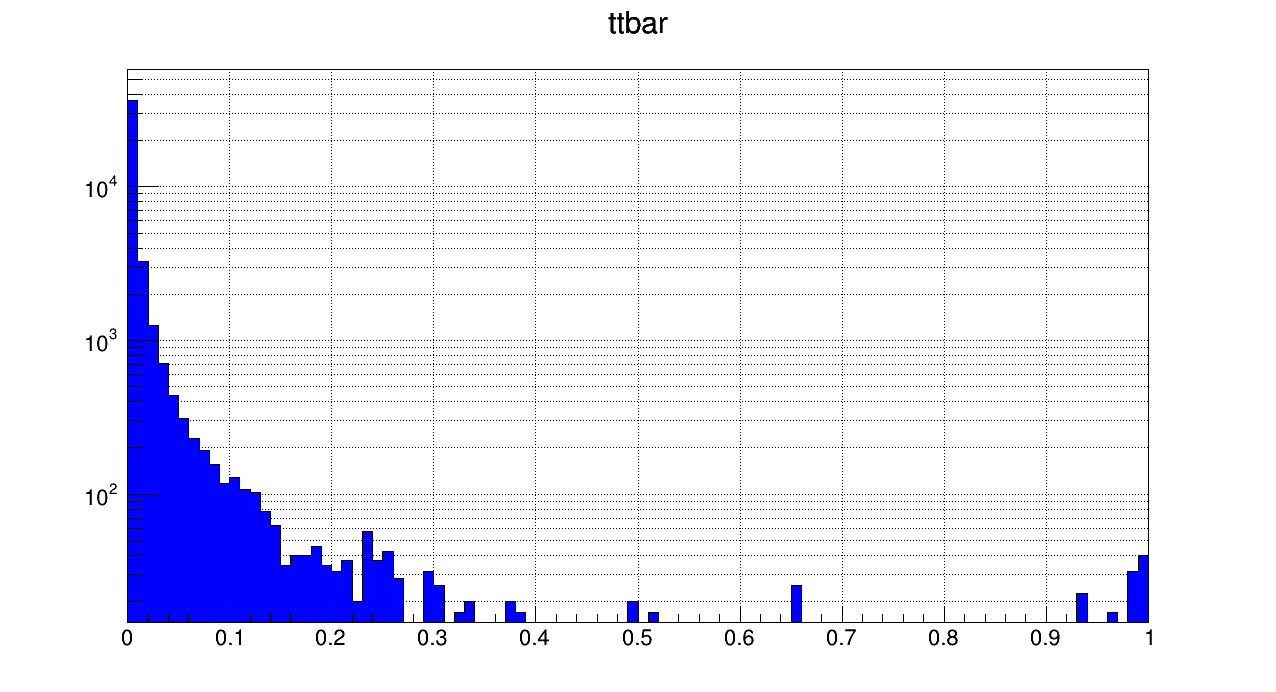

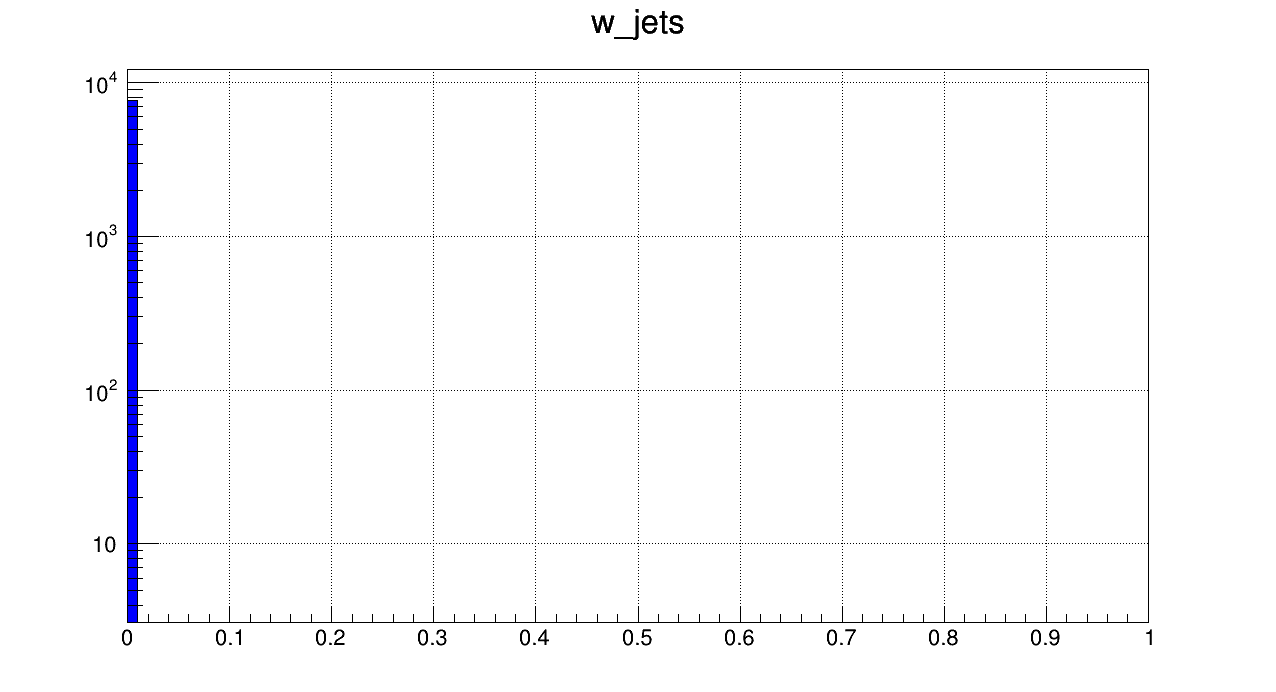

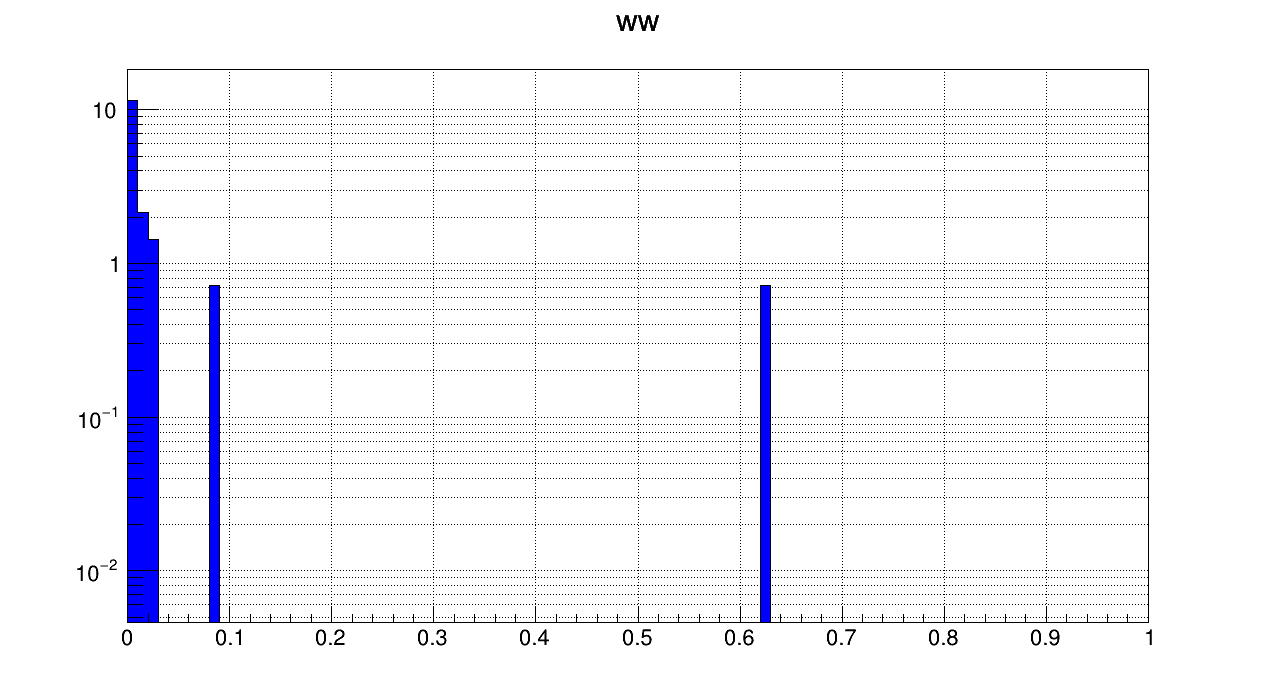

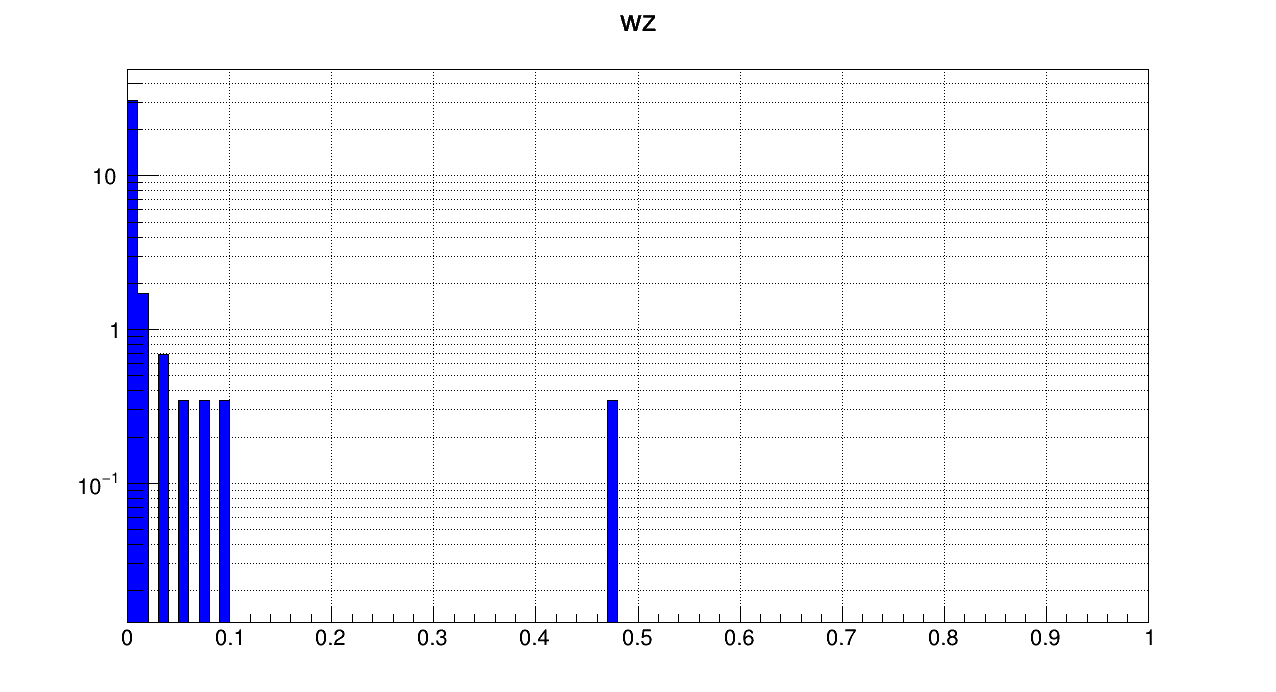

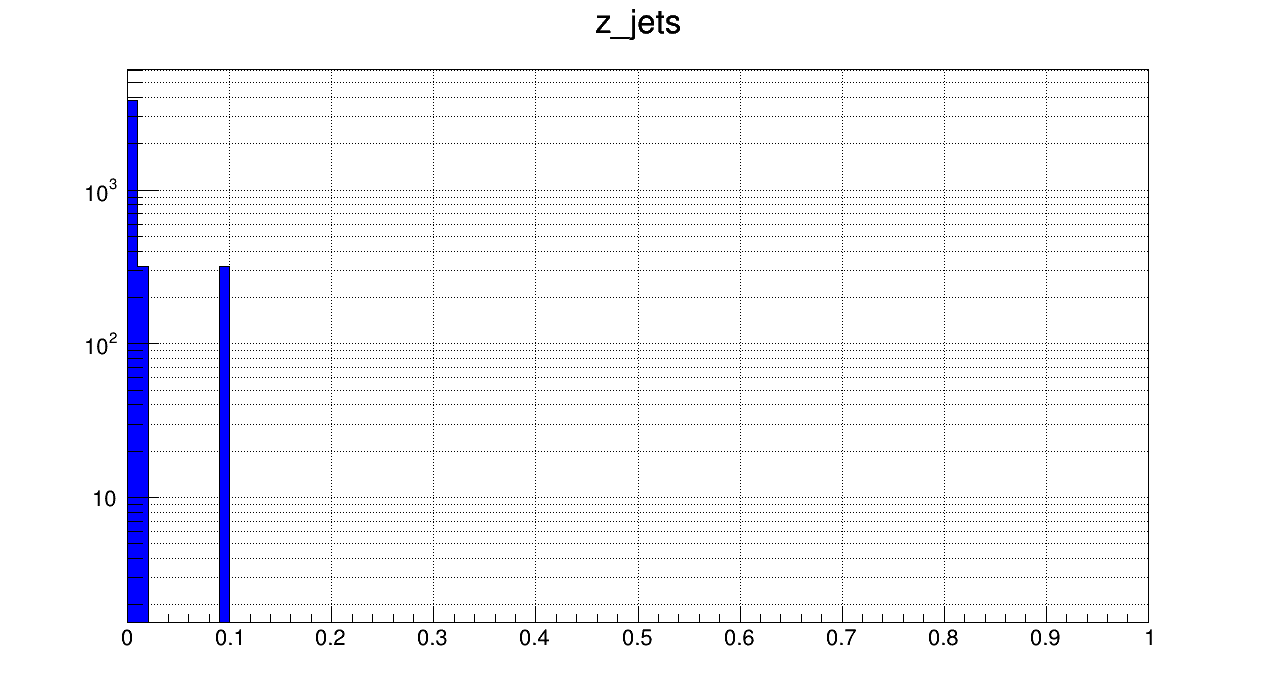

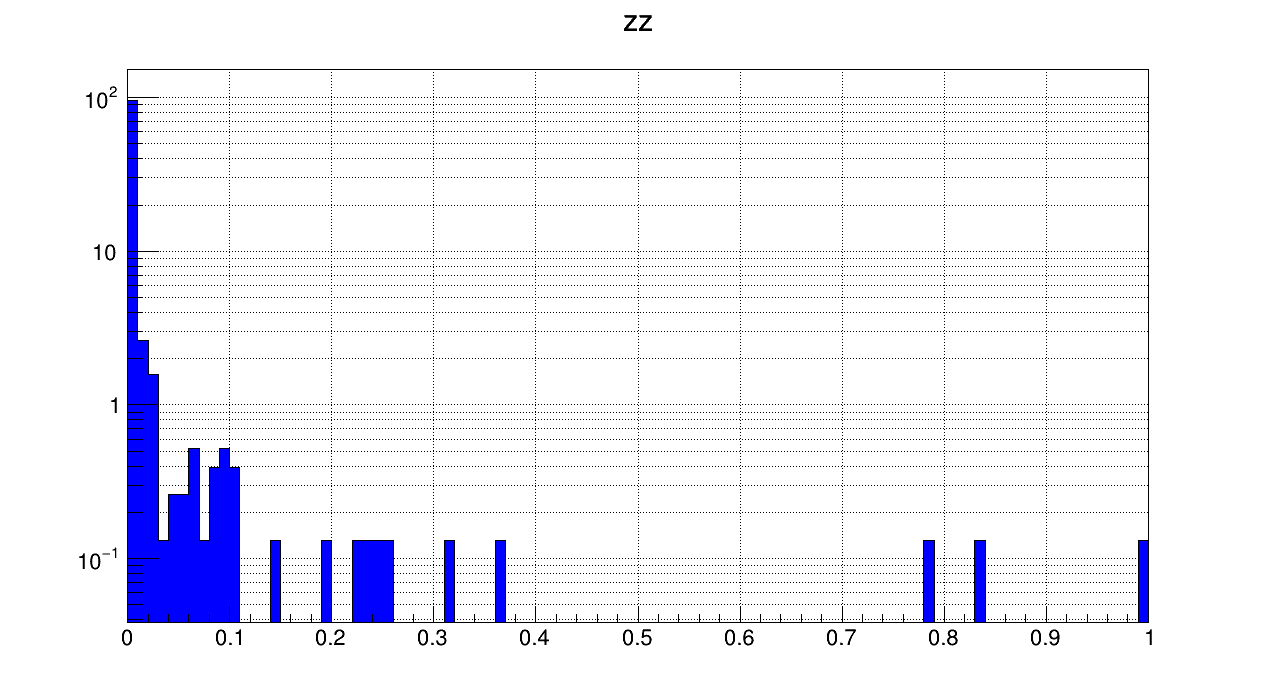

In [18]:
from IPython.display import Image, display
import os
listOfImageNames=[]
files=next(os.walk(images_folder))[2]
for file in files:
    if ".png" in file:
        listOfImageNames+=[file]
listOfImageNames.sort()
for imageName in listOfImageNames:
    display(Image(filename=os.path.join(os.getcwd(),images_folder,imageName)))
    os.remove(os.path.join(os.getcwd(),images_folder,imageName))

In [19]:
histograms

{'LQ_LQ_1000': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629feb6ebb0>},
 'Tau_LQ_1000': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a36e00850>},
 'ttbar': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a04c82490>},
 'stop': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629fec42bf0>},
 'z_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629fee3fff0>},
 'w_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629ffe7c1e0>},
 'ww': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629fe898240>},
 'wz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a36e14440>},
 'zz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a36e043b0>}}

In [20]:
threshold=0.8

In [21]:
integral=0
for channel in channels:
    h=histograms[name][channel]
    gbin1=h.FindBin(threshold)
    gbin2=h.GetNbinsX()
    integral+=h.Integral(gbin1,gbin2)
integral

970.0040472149849

In [22]:
actual_signal_yield=0
for name in signal_names:
    integral=0
    for channel in channels:
        h=histograms[name][channel]
        gbin1=h.FindBin(threshold)
        gbin2=h.GetNbinsX()
        integral+=h.Integral(gbin1,gbin2)
    integral
    actual_signal_yield+=integral
print(signal_names,actual_signal_yield)

['LQ_LQ_1000', 'Tau_LQ_1000'] 1189.1958537697792


In [23]:
actual_bkg_yield=0
for name in bkg_names:
    integral=0
    for channel in channels:
        h=histograms[name][channel]
        gbin1=h.FindBin(threshold)
        gbin2=h.GetNbinsX()
        integral+=h.Integral(gbin1,gbin2)
    actual_bkg_yield+=integral
print(bkg_names,actual_bkg_yield)

['ttbar', 'stop', 'z_jets', 'w_jets', 'ww', 'wz', 'zz'] 288.80982980132103


In [24]:
significance=actual_signal_yield/math.sqrt(actual_signal_yield+actual_bkg_yield)
significance

30.93252227038284

In [25]:
def get_yield_by_names(hists,names,threshold):
    signal_yield=0
    for name in names:
        integral=0
        for channel in channels:
            h=histograms[name][channel]
            gbin1=h.FindBin(threshold)
            gbin2=h.GetNbinsX()
            integral+=h.Integral(gbin1,gbin2)
        integral
        signal_yield+=integral
    return signal_yield

In [26]:
def get_sig_by_threshold(histos,threshold=0.5):
    actual_signal_yield=get_yield_by_names(histos,signal_names,threshold)
    actual_bkg_yield=get_yield_by_names(histos,bkg_names,threshold)
    return (actual_signal_yield)/math.sqrt((actual_signal_yield)+(actual_bkg_yield)+1e-6)

In [27]:
get_sig_by_threshold(histograms,0.99)

31.588347630837923

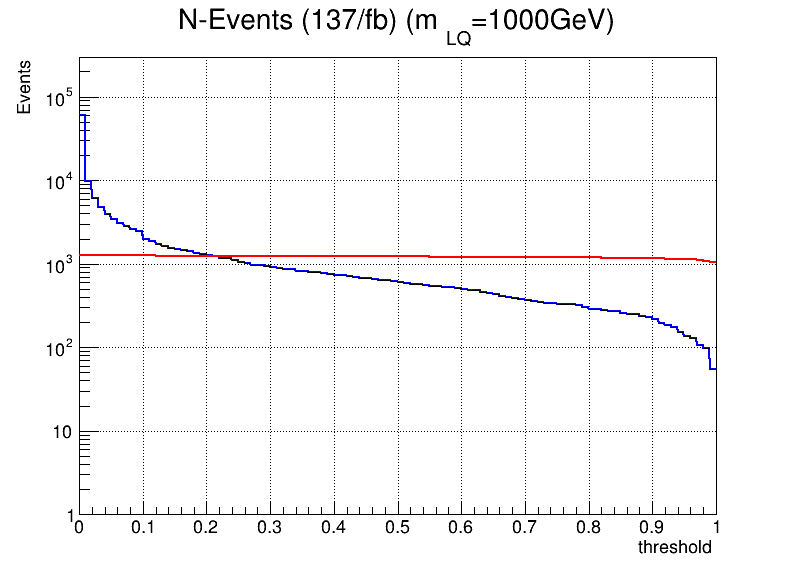

In [28]:
x=[]
y1=[]
y2=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y1+=[get_yield_by_names(histograms,bkg_names,x[i])]
    y2+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y1  = np.array(  y1 )
y2  = np.array(  y2 )

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph1=TGraph(n, x, y1)
graph1.SetTitle(f"N-Events (137/fb) (m_{{LQ}}={mass}GeV);threshold; Events")
graph1.GetXaxis().SetLimits(0,1)
graph1.GetHistogram().SetMinimum(1)
graph1.GetHistogram().SetMaximum(3e5)
graph1.Draw("ALP")
graph1.SetLineColor(ROOT.kBlue)
graph1.SetLineWidth(2)

graph2=TGraph(n, x, y2)
graph2.Draw("l-same")
graph2.SetLineColor(ROOT.kRed)
graph2.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


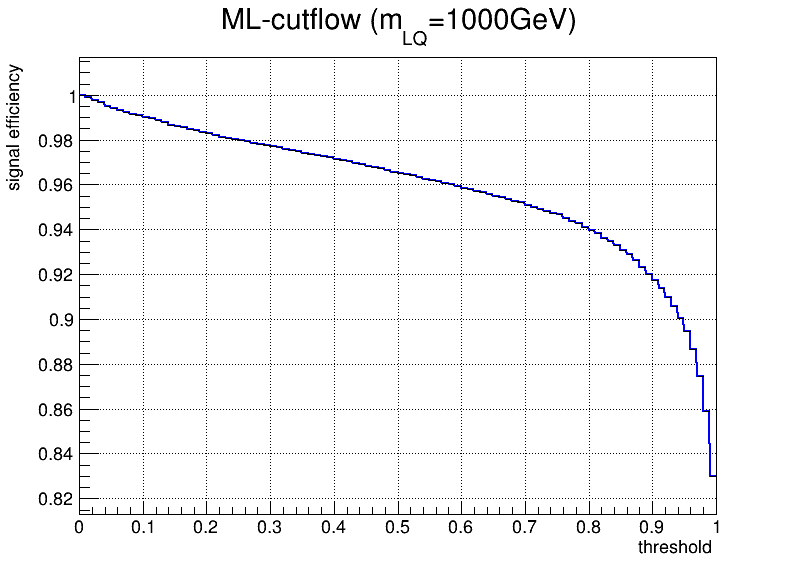

In [29]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle(f"ML-cutflow (m_{{LQ}}={mass}GeV);threshold;signal efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


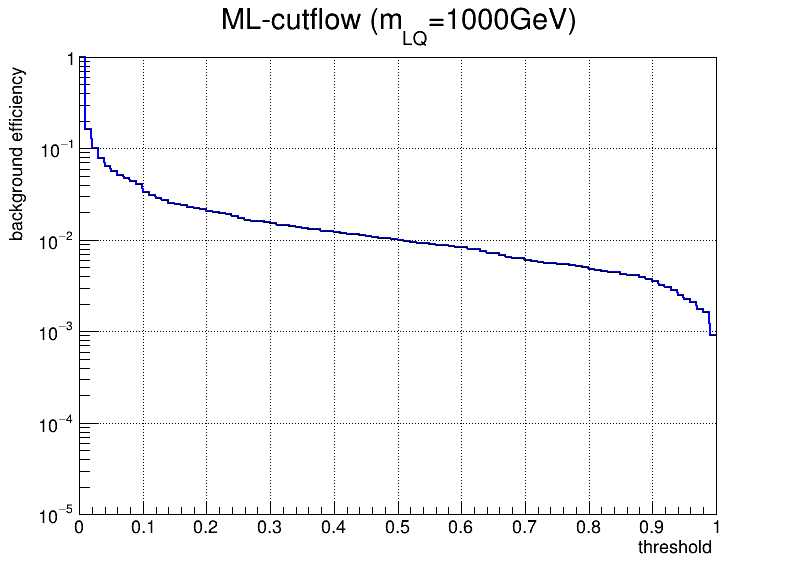

In [30]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,bkg_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle(f"ML-cutflow (m_{{LQ}}={mass}GeV);threshold;background efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.GetHistogram().SetMinimum(1e-5)
graph.GetHistogram().SetMaximum(1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


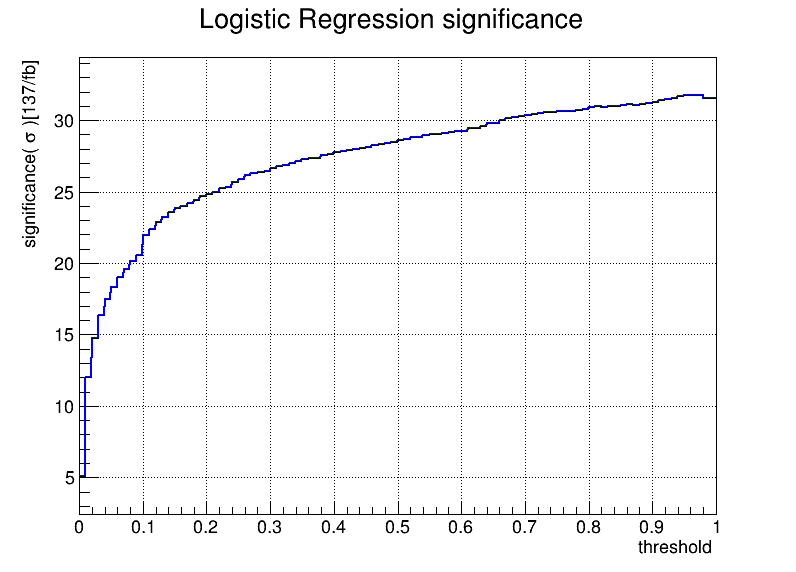

In [31]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x )
y  = np.array(  y )
c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("Logistic Regression significance;threshold;significance(#sigma )[137/fb]")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

In [32]:
x=[]
y=[]
n=100
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x  )
y  = np.array(  y  )
print(y)

[ 5.07954553 11.99429416 14.77748314 16.33228976 17.50477571 18.35234088
 19.03259805 19.61054239 20.11846239 20.55723949 21.96853184 22.41701281
 22.86880005 23.25430031 23.59793361 23.85749398 24.01449222 24.22807967
 24.42122231 24.65980279 24.8341466  24.99699638 25.2277376  25.34421421
 25.66185299 25.87542859 26.13402646 26.31232368 26.36980952 26.36980952
 26.65147992 26.82293015 26.89757056 27.0210984  27.16837279 27.27363514
 27.32216439 27.36943973 27.54936395 27.65489062 27.74129292 27.81155645
 27.8819901  27.97670274 28.07631982 28.13496519 28.23174101 28.33291219
 28.40861939 28.49486323 28.63627143 28.69563688 28.81962391 28.85007132
 28.93873709 29.00195142 29.06133667 29.13014975 29.13014975 29.21848112
 29.27738436 29.42441639 29.46820654 29.62085004 29.77381441 29.8098045
 30.0318457  30.1617613  30.19569905 30.26261877 30.35087589 30.43295642
 30.52539526 30.60474231 30.58514583 30.64001849 30.61128677 30.64201989
 30.70358107 30.79937999 30.93252226 30.95957986 30.

In [33]:
histograms

{'LQ_LQ_1000': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629feb6ebb0>},
 'Tau_LQ_1000': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a36e00850>},
 'ttbar': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a04c82490>},
 'stop': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629fec42bf0>},
 'z_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629fee3fff0>},
 'w_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629ffe7c1e0>},
 'ww': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5629fe898240>},
 'wz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a36e14440>},
 'zz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562a36e043b0>}}

In [34]:
from ROOT import TFile
import os
f = TFile(os.path.join(images_folder,"Logistic_Regresion.root"),"RECREATE")
for signal in histograms:
    h=histograms[signal][channel]
    h.Write(h.GetName().removesuffix(channel))
f.ls()

TFile**		MLQ_1000/b_b_tau_tau_hadronic/Logistic_Regresion.root	
 TFile*		MLQ_1000/b_b_tau_tau_hadronic/Logistic_Regresion.root	
  KEY: TH1F	LQ_LQ_1000_;1	LQ_LQ_1000_b_b_tau_tau_hadronic
  KEY: TH1F	Tau_LQ_1000_;1	Tau_LQ_1000_b_b_tau_tau_hadronic
  KEY: TH1F	ttbar_;1	ttbar_b_b_tau_tau_hadronic
  KEY: TH1F	stop_;1	stop_b_b_tau_tau_hadronic
  KEY: TH1F	z_jets_;1	z_jets_b_b_tau_tau_hadronic
  KEY: TH1F	w_jets_;1	w_jets_b_b_tau_tau_hadronic
  KEY: TH1F	ww_;1	ww_b_b_tau_tau_hadronic
  KEY: TH1F	wz_;1	wz_b_b_tau_tau_hadronic
  KEY: TH1F	zz_;1	zz_b_b_tau_tau_hadronic


In [39]:

h.GetBinContent(h.GetNbinsX())

0.13100509345531464

In [36]:
h.GetNbinsX()

100

In [37]:
h.GetMinimumBin()

12

In [ ]:
for bin_ in range(h.GetNbinsX()):
    